In [30]:
import matplotlib.pyplot as plt
import numpy as np
import math

In [132]:
# Define constants and parameters
dt = 0.01  # Time step
Q = np.eye(4) * 0.001  # Process noise covariance
R_acc = np.eye(3) * 0.01  # Accelerometer measurement noise covariance
R_gyro = np.eye(3) * 0.001  # Gyroscope measurement noise covariance

In [133]:
# Define helper functions
def normalize_quaternion(q):
    return q / np.linalg.norm(q)

def euler_to_quaternion(roll, pitch, yaw):
    """
    Convert Euler angles (roll, pitch, yaw) to quaternion.
    :param roll: Roll angle (in radians)
    :param pitch: Pitch angle (in radians)
    :param yaw: Yaw angle (in radians)
    :return: Quaternion [qw, qx, qy, qz]
    """
    cy = np.cos(yaw * 0.5)
    sy = np.sin(yaw * 0.5)
    cp = np.cos(pitch * 0.5)
    sp = np.sin(pitch * 0.5)
    cr = np.cos(roll * 0.5)
    sr = np.sin(roll * 0.5)

    qw = cr * cp * cy + sr * sp * sy
    qx = sr * cp * cy - cr * sp * sy
    qy = cr * sp * cy + sr * cp * sy
    qz = cr * cp * sy - sr * sp * cy

    return np.array([qw, qx, qy, qz])

def quaternion_to_euler(q):
    """
    Convert quaternion to Euler angles (roll, pitch, yaw)
    :param q: Quaternion [qw, qx, qy, qz]
    :return: Euler angles [roll, pitch, yaw] in radians
    """
    # Extract quaternion components
    qw, qx, qy, qz = q

    # Roll (x-axis rotation)
    sinr_cosp = 2.0 * (qw * qx + qy * qz)
    cosr_cosp = 1.0 - 2.0 * (qx * qx + qy * qy)
    roll = np.arctan2(sinr_cosp, cosr_cosp)

    # Pitch (y-axis rotation)
    sinp = 2.0 * (qw * qy - qz * qx)
    if np.abs(sinp) >= 1:
        pitch = np.copysign(np.pi / 2, sinp)  # Use +-pi/2 if out of range
    else:
        pitch = np.arcsin(sinp)

    # Yaw (z-axis rotation)
    siny_cosp = 2.0 * (qw * qz + qx * qy)
    cosy_cosp = 1.0 - 2.0 * (qy * qy + qz * qz)
    yaw = np.arctan2(siny_cosp, cosy_cosp)

    return [roll, pitch, yaw]

def quaternion_multiply(q0, q1):
    # w1, x1, y1, z1 = q1
    # w2, x2, y2, z2 = q2
    # w = w1 * w2 - x1 * x2 - y1 * y2 - z1 * z2
    # x = w1 * x2 + x1 * w2 + y1 * z2 - z1 * y2
    # y = w1 * y2 - x1 * z2 + y1 * w2 + z1 * x2
    # z = w1 * z2 + x1 * y2 - y1 * x2 + z1 * w2

    w0, x0, y0, z0 = q0
    w1, x1, y1, z1 = q1

    return np.array(
        [-x1 * x0 - y1 * y0 - z1 * z0 + w1 * w0,
        x1 * w0 + y1 * z0 - z1 * y0 + w1 * x0,
        -x1 * z0 + y1 * w0 + z1 * x0 + w1 * y0,
        x1 * y0 - y1 * x0 + z1 * w0 + w1 * z0])

def quaternion_to_rotation_matrix(q):
    w, x, y, z = q
    return np.array([
        [1 - 2*(y**2 - z**2), 2*(x*y - w*z), 2*(x*z + w*y)],
        [2*x*y + 2*w*z, 1 - 2*x**2 - 2*z**2, 2*y*z - 2*w*x],
        [2*x*z - 2*w*y, 2*y*z + 2*w*x, 1 - 2*x**2 - 2*y**2]
    ])

    # return np.array([
    #     [w**2 + x**2 - y**2 - z**2,   2*(x*y - w*z),             2*(x*z + w*y)],
    #     [2*(x*y + w*z)            ,   w**2 - x**2 + y**2 - z**2, 2*(y*z - w*x)],
    #     [2*(x*z - w*y)            ,   2*(w*x + y*z)            , w**2 - x**2 - y**2 + z**2]])

def get_H(q_est):
    g_x, g_y, g_z = [0,0,-1]
    q_w, q_x, q_y, q_z = q_est
    return 2 * np.array([
            [g_x*q_w + g_y*q_z - g_z*q_y , g_x*q_x + g_y*q_y + g_z*q_z , -g_x*q_y + g_y*q_x - g_z*q_w , -g_x*q_z + g_y*q_w + g_z*q_x],
            [-g_x*q_z + g_y*q_w + g_z*q_x , g_x*q_y - g_y*q_x + g_z*q_w ,  g_x*q_x + g_y*q_y + g_z*q_z , -g_x*q_w - g_y*q_z + g_z*q_y],
            [g_x*q_y - g_y*q_x + g_z*q_w , g_x*q_z - g_y*q_w - g_z*q_x ,  g_x*q_w + g_y*q_z - g_z*q_y ,  g_x*q_x + g_y*q_y + g_z*q_z]])

def get_h(q_est):
    rot = quaternion_to_rotation_matrix(q_est)
    h = rot.T @ np.array([0, 0, -1])  # Gravity direction in body frame

    return h


def get_accelerometer_measurement():
    return np.array([0,0,-1])

In [166]:
class IMU:
    def __init__(self):
        self.ctr = 0
        self.q = np.array([1,0,0,0]) # Starting rotation
        self.omega = np.array([0, 0, 0]) # roll, pitch, yaw in rad/s

    def step_sim(self):
        self.ctr += 1

        self.omega = np.array([math.sin(self.ctr/10.0), math.sin(self.ctr/8.0), math.sin(self.ctr/7.777)])
        print(self.omega)

        omega_skew = np.array([[0, -self.omega[0], -self.omega[1], -self.omega[2]],
                           [self.omega[0], 0, self.omega[2], -self.omega[1]],
                           [self.omega[1], -self.omega[2], 0, self.omega[0]],
                           [self.omega[2], self.omega[1], -self.omega[0], 0]])
        
        # Integrate velocity to current quaternion estimate
        self.q = self.q + 0.5 * dt * omega_skew @ self.q
        self.q = normalize_quaternion(self.q)
    
    def get_accelerometer_measurement(self):

        # Step simulation
        self.step_sim()

        rot = quaternion_to_rotation_matrix(self.q)
        gravity_in_body_frame = rot.T @ np.array([0, 0, -1])  # Gravity direction in body frame

        return gravity_in_body_frame
    
    def get_gyroscope_measurement(self):
        # theta_diff = self.roll_angle - self.prev_roll_angle
        # return np.array([math.cos(theta_diff/1.0),math.sin(theta_diff/2),0, 0])
        # return np.array([0,0,0])
        return self.omega
    
    def get_real_q(self):
        return self.q

In [171]:
# Initial state estimate
q_est = np.array([1, 0, 0, 0])  # Initial quaternion estimate
P = np.eye(4) * 0.1  # Initial covariance matrix

# History for plotting
num_iterations = 150
angle_history = np.zeros((3, num_iterations))
real_angle_history = np.zeros((3, num_iterations))

imu = IMU()

# Main EKF loop
for i in range(num_iterations):  # Adjust num_iterations as needed
    # Prediction step: Propagate state estimate and covariance
    omega = imu.get_gyroscope_measurement()  # Get gyroscope measurement (angular velocity)
    omega_skew = np.array([[0, -omega[0], -omega[1], -omega[2]],
                           [omega[0], 0, omega[2], -omega[1]],
                           [omega[1], -omega[2], 0, omega[0]],
                           [omega[2], omega[1], -omega[0], 0]])

    # Integrate velocity to current quaternion estimate
    q_est = q_est + 0.5 * dt * omega_skew @ q_est
    q_est = normalize_quaternion(q_est)
    F = np.eye(4) + 0.5 * dt * omega_skew
    P = F @ P @ F.T + Q # TODO: Maybe add the covariance depending on w as in https://ahrs.readthedocs.io/en/latest/filters/ekf.html

    # Measurement update step: Update state estimate and covariance based on accelerometer measurement

    z = imu.get_accelerometer_measurement()  # Get accelerometer measurement
    h = get_h(q_est)

    v = z-h

    H = get_H(q_est)

    S = H@P@H.T + R_acc

    K = P @ H.T @ np.linalg.inv(S) # Kalman gain

    q_est = q_est + K @ v  # Update state estimate
    q_est = normalize_quaternion(q_est)
    P = (np.eye(4) - K @ H) @ P  # Update covariance matrix

    angle_history[:, i] = quaternion_to_euler(q_est)
    real_angle_history[:, i] = quaternion_to_euler(imu.get_real_q())

[0.09983342 0.12467473 0.12823025]
[0.19866933 0.24740396 0.25434326]
[0.29552021 0.36627253 0.37625678]
[0.38941834 0.47942554 0.49195787]
[0.47942554 0.58509727 0.59953616]
[0.56464247 0.68163876 0.69721542]
[0.64421769 0.7675435  0.78338286]
[0.71735609 0.84147098 0.85661574]
[0.78332691 0.90226759 0.91570491]
[0.84147098 0.94898462 0.95967474]
[0.89120736 0.98089306 0.98779923]
[0.93203909 0.99749499 0.99961402]
[0.96355819 0.99853134 0.99492404]
[0.98544973 0.98398595 0.97380671]
[0.99749499 0.95408578 0.93661072]
[0.9995736  0.90929743 0.8839502 ]
[0.99166481 0.85031979 0.81669465]
[0.97384763 0.7780732  0.73595454]
[0.94630009 0.69368503 0.64306296]
[0.90929743 0.59847214 0.53955368]
[0.86320937 0.4939203  0.42713574]
[0.8084964  0.38166099 0.3076653 ]
[0.74570521 0.26344599 0.18311496]
[0.67546318 0.14112001 0.05554117]
[ 0.59847214  0.01659189 -0.07294966]
[ 0.51550137 -0.10819513 -0.20023601]
[ 0.42737988 -0.23129381 -0.32421624]
[ 0.33498815 -0.35078323 -0.44284328]
[ 0.2392

TypeError: 'Axes' object is not subscriptable

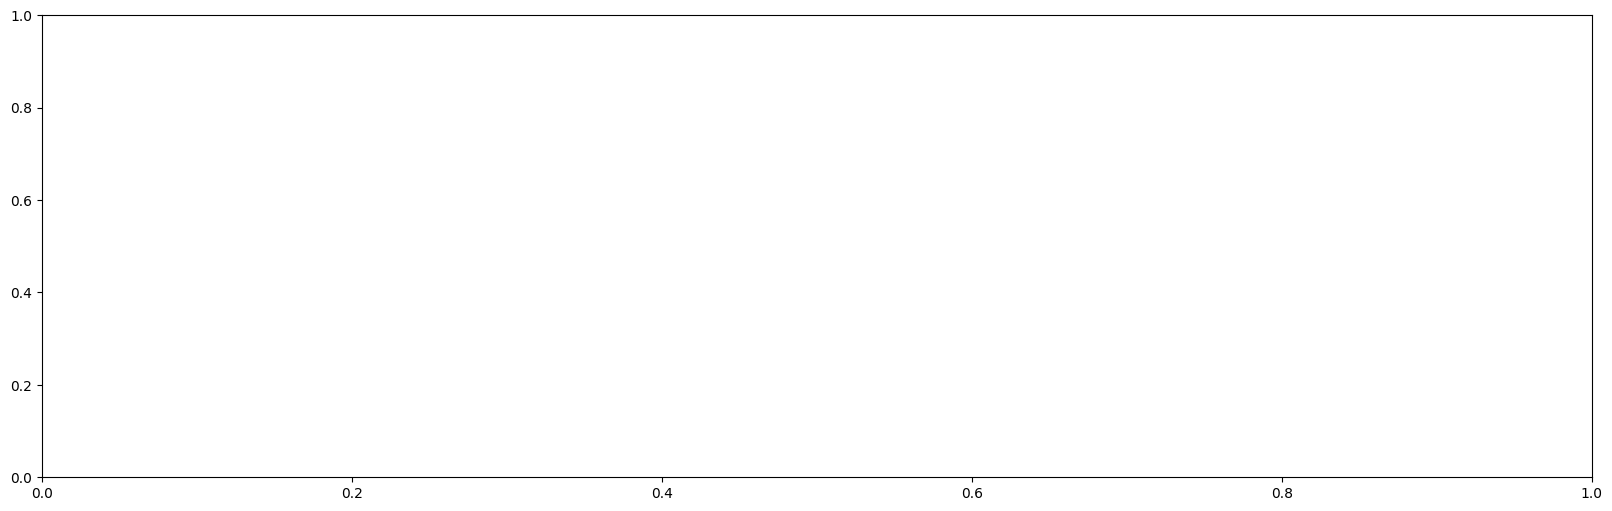

In [173]:
ts = np.arange(num_iterations) * dt
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 6))
ax[0].set_title("Estimated Angles")
ax[0].plot(ts, angle_history[0], label='roll', linewidth=1)
ax[0].plot(ts, angle_history[1], label='pitch', linewidth=1)
ax[0].plot(ts, angle_history[2], label='yaw', linewidth=1)

ax[0].plot(ts, real_angle_history[0],'--', label='GT roll', linewidth=1)
ax[0].plot(ts, real_angle_history[1],'--', label='GT pitch', linewidth=1)
ax[0].plot(ts, real_angle_history[2],'--', label='GT yaw', linewidth=1)

ax[0].legend()
ax[0].grid(True)

# ax[1].set_title("True Angles")
# ax[1].plot(ts, real_angle_history[0], label='GT roll', linewidth=1)
# ax[1].plot(ts, real_angle_history[1], label='GT pitch', linewidth=1)
# ax[1].plot(ts, real_angle_history[2], label='GT yaw', linewidth=1)
# ax[1].legend()
# ax[1].grid(True)
# ax[1].set_title("Velocity")
# ax[1].plot(ts, Xs[1], 'r', label='est. dtheta')
# ax[1].plot(ts, Xs_actual[1], 'g--', label='actual dtheta')
# ax[1].plot(ts, sensor_readings, 'bx', label='sensor readings')
# ax[1].legend()